In [2]:


import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

MEAN, STD = 0.13, 0.31


In [3]:
# KL divergence of predicted parameters from uniform Dirichlet distribution
# from https://arxiv.org/abs/1806.01768
# code based on:
# https://bariskurt.com/kullback-leibler-divergence-between-two-dirichlet-and-beta-distributions/
def dirichlet_reg(alpha, y):
    # dirichlet parameters after removal of non-misleading evidence (from the label)
    alpha = y + (1 - y) * alpha

    # uniform dirichlet distribution
    beta = torch.ones_like(alpha)

    sum_alpha = alpha.sum(-1)
    sum_beta = beta.sum(-1)

    t1 = sum_alpha.lgamma() - sum_beta.lgamma()
    t2 = (alpha.lgamma() - beta.lgamma()).sum(-1)
    t3 = alpha - beta
    t4 = alpha.digamma() - sum_alpha.digamma().unsqueeze(-1)

    kl = t1 - t2 + (t3 * t4).sum(-1)
    return kl.mean()


# Eq. (5) from https://arxiv.org/abs/1806.01768:
# Sum of squares loss
def dirichlet_mse(alpha, y):
    sum_alpha = alpha.sum(-1, keepdims=True)
    p = alpha / sum_alpha
    t1 = (y - p).pow(2).sum(-1)
    t2 = ((p * (1 - p)) / (sum_alpha + 1)).sum(-1)
    mse = t1 + t2
    return mse.mean()


def evidential_classification(alpha, y, lamb=1.0):
    num_classes = alpha.shape[-1]
    y = F.one_hot(y, num_classes)
    return dirichlet_mse(alpha, y) + lamb * dirichlet_reg(alpha, y)

In [7]:
class Dirichlet(nn.Module):
    def __init__(self, in_features, out_units):
        super().__init__()
        self.dense = nn.Linear(in_features, out_units)
        self.out_units = out_units

    def evidence(self, x):
        return F.relu(x)
        # return F.softplus(x)

    def forward(self, x):
        out = self.dense(x)
        alpha = self.evidence(out) + 1
        return alpha

In [8]:
@torch.no_grad()
def rotation_uncertainty(img, model):
    m = 180
    n = m // 10 + 1
    degs = torch.linspace(0, m, n)
    imgs, probs, uncertainty = [], [], []
    for deg in degs:
        img_ = TF.rotate(img, float(deg), fill=-MEAN / STD)
        imgs.append(img_.squeeze().cpu())
        alpha = model(img_.unsqueeze(0)).squeeze().cpu()
        probs.append(alpha / alpha.sum())
        uncertainty.append(10 / alpha.sum())

    uncertainty = torch.stack(uncertainty)
    probs = torch.stack(probs)
    imgs = torch.cat(imgs, dim=1)

    fig, (ax1, ax2) = plt.subplots(
        2, 1, gridspec_kw={"height_ratios": [8, 1]}, figsize=(5, 3), dpi=200
    )
    fig.subplots_adjust(hspace=0.5)
    ax1.plot(degs, uncertainty, label="Unc.", marker="s")
    ax1.plot(degs, probs[:, 1], label="1", color="k", marker="s")
    ax1.set_ylabel("Probability")
    ax1.set_xlabel("Rotation Degrees")
    ax1.legend()

    ax2.imshow(1 - (imgs * STD + MEAN), cmap="gray")
    ax2.axis(False)

    plt.savefig(f"mnist.png")

epoch: 0 acc: 0.3725000023841858
epoch: 1 acc: 0.37129998207092285
epoch: 2 acc: 0.3716999888420105
epoch: 3 acc: 0.37770000100135803
epoch: 4 acc: 0.3730999827384949
epoch: 5 acc: 0.3752000033855438
epoch: 6 acc: 0.38040000200271606
epoch: 7 acc: 0.3790999948978424
epoch: 8 acc: 0.3723999857902527
epoch: 9 acc: 0.37529999017715454


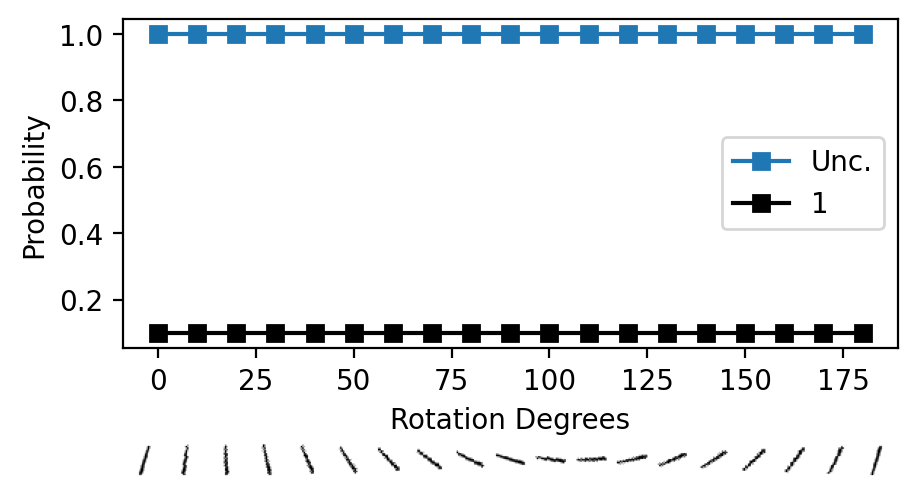

In [11]:
#
seed = 3407

torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = T.Compose([T.ToTensor(), T.Normalize(MEAN, STD)])
train_ds = MNIST("./data", train=True, download=True, transform=transform)
test_ds = MNIST("./data", train=False, download=True, transform=transform)

lenet = nn.Sequential(
    nn.Conv2d(1, 6, 5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    Dirichlet(84, 10),
)
lenet.to(device)

optimizer = torch.optim.Adam(lenet.parameters(), lr=1e-3, weight_decay=0.005)

for epoch in range(10):
    lenet.train()
    for x, y in DataLoader(train_ds, batch_size=1000, shuffle=True):
        x = x.to(device)
        y = y.to(device)
        pred = lenet(x)
        loss = evidential_classification(pred, y, lamb=min(1, epoch / 10))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        lenet.eval()
        correct, total = 0, 0
        for x, y in DataLoader(test_ds, batch_size=1000):
            x = x.to(device)
            y = y.to(device)
            pred = lenet(x)
            correct += (pred.argmax(-1) == y).sum()
            total += y.shape[0]

        acc = (correct / total).item()
        print("epoch:", epoch, "acc:", acc)

# show uncertainty with rotation with one of the "1" examples
rotation_uncertainty(test_ds[2][0].to(device), lenet)